In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023


In [5]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# IPMI 2023 FEM box experiment

In [6]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/IPMI-2023'

In [7]:
# define the job template and name format

template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
source activate MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{noise_ratio:.0e}_{pde_name}'

# define the parameter space

fem_box_space = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)
fem_box_space2 = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    omega=30,
    pde_name=['hetero2'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)
fem_box_space3 = ps.ParamSpace(
    data_name='fem_box',
    xarray_dir='../../../data/BIOQIC/fem_box',
    example_id=[50, 60, 70, 80, 90, 100],
    frequency='auto',
    noise_ratio=[0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    omega=30,
    pde_name=['helmholtz', 'hetero'],
    pde_init_weight=1e-10,
    pde_loss_weight=1e-8,
    polar_input=0,
)

param_space = fem_box_space3
len(param_space)

72

In [8]:
name.format(**list(param_space)[0])

'train_fem_box_50_0e+00_helmholtz'

In [9]:
%autoreload

#expt_name = '2022-11-23_fem_box_init'
#expt_name = '2022-11-26_fem_box_hetero2'
expt_name = '2022-12-1_fem_box_noise'

#jobs = ps.submit(template, name, param_space, work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

jobs = pd.read_csv(f'{expt_name}.jobs')

In [10]:
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs)[status_cols]
status

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
13413377,train_fem_box_50_0e+00_helmholtz,NaN,NaN,NaN,v015.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413378,train_fem_box_50_0e+00_hetero,NaN,NaN,NaN,v024.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413379,train_fem_box_50_1e-05_helmholtz,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413380,train_fem_box_50_1e-05_hetero,NaN,NaN,NaN,v032.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413381,train_fem_box_50_1e-04_helmholtz,NaN,NaN,NaN,v032.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
...,...,...,...,...,...,...
13413444,train_fem_box_100_1e-03_hetero,NaN,NaN,NaN,v028.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413445,train_fem_box_100_1e-02_helmholtz,NaN,NaN,NaN,v027.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n
13413446,train_fem_box_100_1e-02_hetero,NaN,NaN,NaN,v025.ib.bridges2.psc.edu\n/ocean/projects/asc1...,Using backend: pytorch\n\n


In [114]:
metrics = ps.metrics(jobs)

# did all models train to completion?
assert (metrics.groupby('job_name')['iteration'].max() == 100e3).all()

# get the final test evaluations
metrics = metrics[metrics.iteration == 100e3]

param_cols = ['pde_name', 'example_id', 'noise_ratio'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
metrics = metrics.unstack(level=[len(param_cols)])

def metric_map(t):
    metric_name, var_name = t
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
metrics

u_pred_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                0.000107   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1         6.0                   all                     NaN   
                                 7.0                   all                     NaN   
                                 8.0                   all                     NaN   
                                 9.0                   all                     NaN   
                                 10.0                  all                     NaN   

                                                                        u_pred_MSAE  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                 
helmholtz 50         0.0         all                   all             9.599483e-09   
                                                       1                        NaN   
                                                       2                        NaN   
                                                       3                        NaN   
                                                       4                        NaN   
...                                                                             ...   
hetero    100        0.1         6.0                   all                      NaN   
                                 7.0                   all                      NaN   
                                 8.0                   all                      NaN   
                                 9.0                   all                      NaN   
                                 10.0                  all                      NaN   

                                                                       u_true_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                
helmholtz 50         0.0         all                   all                0.000107   
                                                       1                       NaN   
                                                       2                       NaN   
                                                       3                       NaN   
                                                       4                       NaN   
...                                                                            ...   
hetero    100        0.1         6.0                   all                     NaN   
                                 7.0                   all                     NaN   
                                 8.0                   all                     NaN   
                                 9.0                   all                     NaN   
                                 10.0                  all                     NaN   

                                                                        lu_pred_MSAV  \
pde_name  example_id noise_ratio spatial_frequency_bin spatial_region                  
helmholtz 50         0.0         all                   all             113058.291674   
                                                       1                         NaN   
                                                       2                         NaN   
                                                       3                         NaN   
                                                       4                         NaN   
...                                                                              ... 

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group_name] = df[group_cols].astype(str).agg(sep.join, axis=1)



<IPython.core.display.Javascript object>


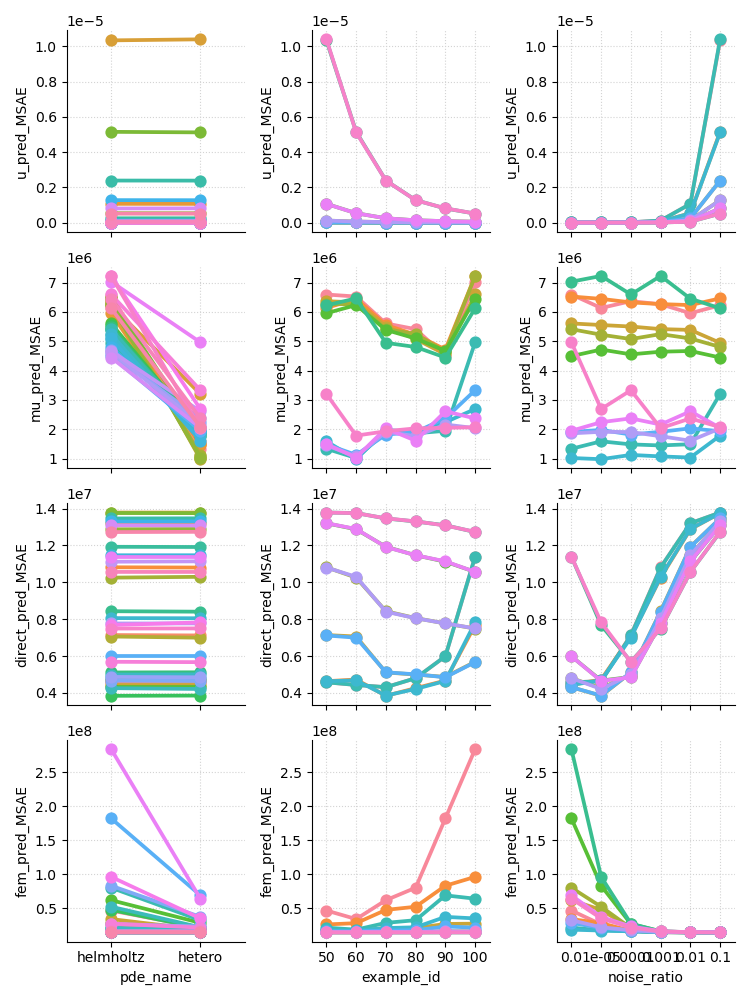

In [115]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')],
    x=param_cols,
    y=['u_pred_MSAE', 'mu_pred_MSAE', 'direct_pred_MSAE', 'fem_pred_MSAE'],
    height=2.5,
    width=2.5,
    legend=False,
    tight=True
)

In [116]:
m['method'] = 'PINN_' + m['pde_name']

direct_helmholtz_m = m[m.pde_name == 'helmholtz'].copy()
direct_helmholtz_m['method'] = 'direct_helmholtz'
for col in m.columns:
    if col.startswith('direct'):
        direct_helmholtz_m[col.replace('direct', 'mu')] = m[col]

fem_helmholtz_m = m[m.pde_name == 'helmholtz'].copy()
fem_helmholtz_m['method'] = 'FEM_helmholtz'
for col in m.columns:
    if col.startswith('fem'):
        fem_helmholtz_m[col.replace('fem', 'mu')] = m[col]
        
fem_hetero_m = m[m.pde_name == 'hetero'].copy()
fem_hetero_m['method'] = 'FEM_hetero'
for col in m.columns:
    if col.startswith('fem'):
        fem_hetero_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([direct_helmholtz_m, fem_helmholtz_m, fem_hetero_m, m])

In [117]:
mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV']
mm['mu_pred_MAD_relative'] = mm['mu_pred_MAD'] / mm['mu_true_MAV']

In [118]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [red, yellow, green, cyan, blue]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

In [119]:
m.columns

Index(['pde_name', 'example_id', 'noise_ratio', 'spatial_frequency_bin',
       'spatial_region', 'u_pred_MSAV', 'u_pred_MSAE', 'u_true_MSAV',
       'lu_pred_MSAV', 'lu_pred_MSAE', 'Lu_true_MSAV', 'pde_grad_MSAV',
       'pde_pred_MSAE', 'mu_pred_MSAE', 'mu_pred_MSAV', 'mu_true_MSAV',
       'direct_pred_MSAV', 'direct_pred_MSAE', 'fem_pred_MSAV',
       'fem_pred_MSAE', 'u_pred_PSD', 'u_diff_PSD', 'u_true_PSD',
       'lu_pred_PSD', 'lu_diff_PSD', 'Lu_true_PSD', 'pde_grad_PSD',
       'pde_diff_PSD', 'mu_diff_PSD', 'mu_pred_PSD', 'mu_true_PSD',
       'direct_pred_PSD', 'direct_diff_PSD', 'fem_pred_PSD', 'fem_diff_PSD',
       'u_pred_MAV', 'u_pred_MAD', 'u_true_MAV', 'lu_pred_MAV', 'lu_pred_MAD',
       'Lu_true_MAV', 'pde_grad_MAV', 'pde_pred_MAD', 'mu_pred_MAD',
       'mu_pred_MAV', 'mu_true_MAV', 'direct_pred_MAV', 'direct_pred_MAD',
       'fem_pred_MAV', 'fem_pred_MAD', 'u_pred_R', 'u_diff_R', 'u_true_R',
       'lu_pred_R', 'lu_diff_R', 'Lu_true_R', 'pde_grad_R', 'pde_diff_R'

<IPython.core.display.Javascript object>


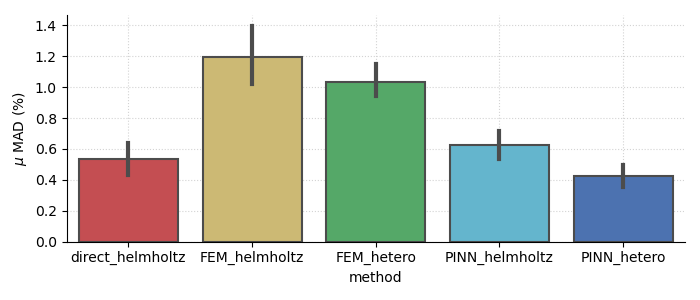

In [140]:
%autoreload

fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ MAD (%)')

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


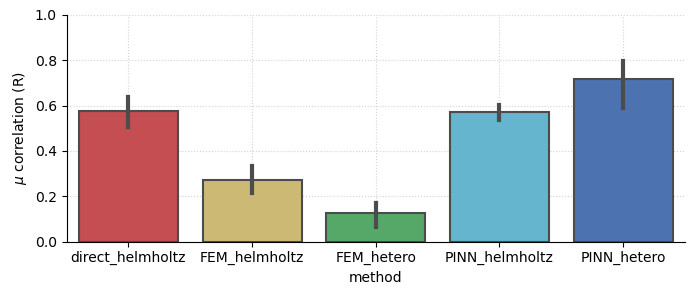

In [141]:
%autoreload

fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & (mm.noise_ratio == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=7,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


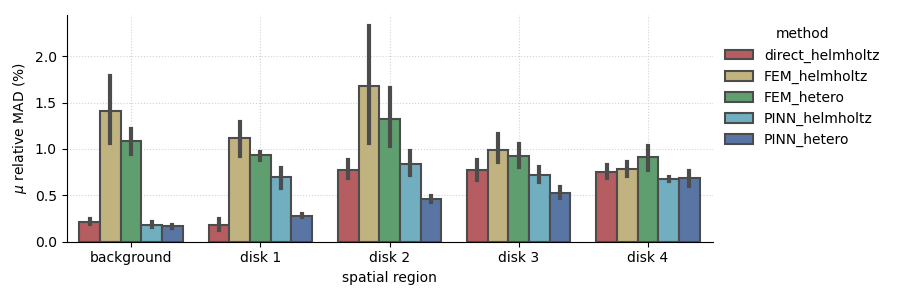

In [142]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='spatial_region',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_xlabel('spatial region')
fig.axes[0].set_xticklabels(['background', 'disk 1', 'disk 2', 'disk 3', 'disk 4'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_region_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


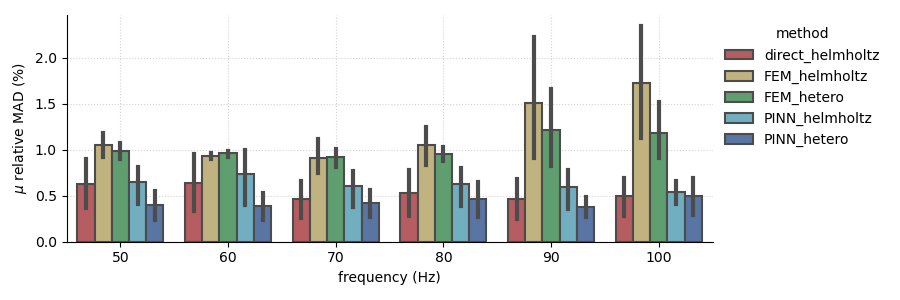

In [143]:
fig = ps.plot(
    mm[(mm.spatial_region != 'all') & (mm.noise_ratio == 0.0)],
    x='example_id',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_xlabel('frequency (Hz)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_frequency_bar_plot.{ext}', bbox_inches='tight', dpi=200)

  result = getattr(ufunc, method)(*inputs, **kwargs)



<IPython.core.display.Javascript object>


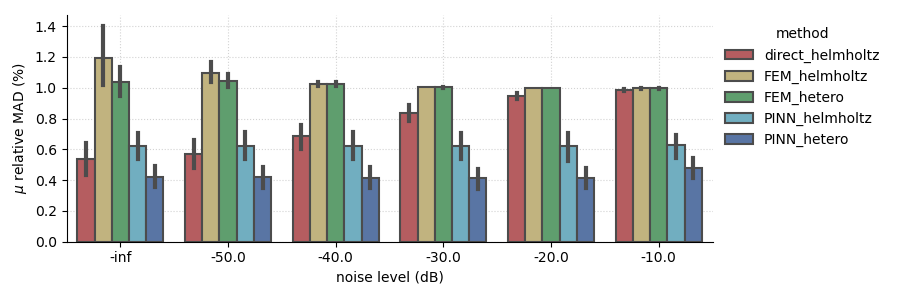

In [144]:
mm['noise_level'] = 10 * np.log10(mm['noise_ratio'])

fig = ps.plot(
    mm[(mm.spatial_region != 'all')],
    x='noise_level',
    y='mu_pred_MAD_relative',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_xlabel('noise level (dB)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


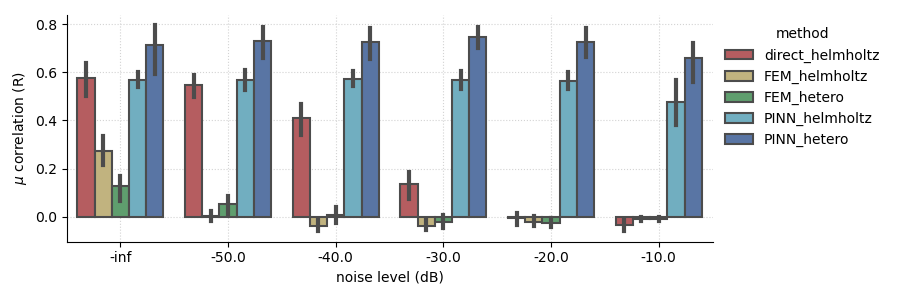

In [145]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all')],
    x='noise_level',
    y='mu_pred_R',
    hue='method',
    height=3,
    width=9,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_xlabel('noise level (dB)')

for ext in ['png', 'pdf']:
    fig.savefig(f'images/fem_box_noise_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [99]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('bright')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue
)

<IPython.core.display.Javascript object>


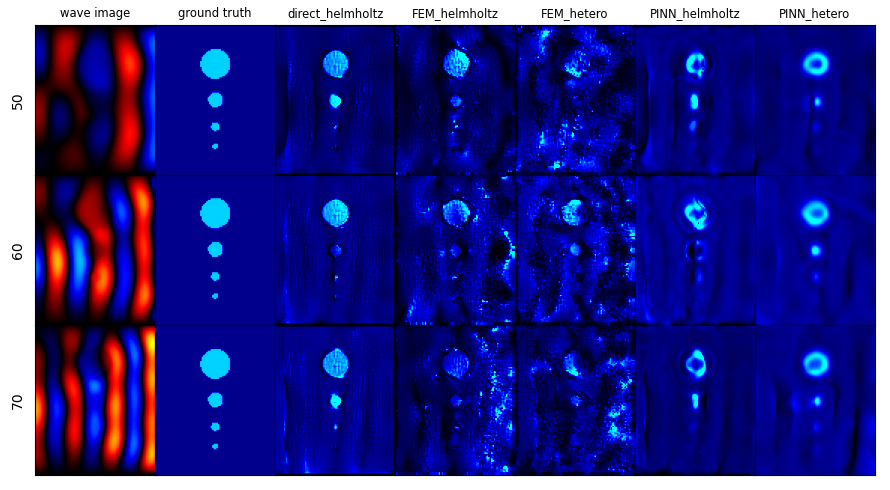

Loading ../data/BIOQIC/fem_box/50/wave.nc
Loading ../data/BIOQIC/fem_box/50/mre.nc
Loading ../data/BIOQIC/fem_box/50/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_hetero/train_fem_box_50_0e+00_hetero_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_helmholtz/train_fem_box_50_0e+00_helmholtz_elastogram.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_50_0e+00_hetero/train_fem_box_50_0e+00_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_0e+00_helmholtz/train_fem_box_60_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_60_0e+00_helmholtz/train_fem_box_60_0e+00_helmholtz_fem.nc

<IPython.core.display.Javascript object>


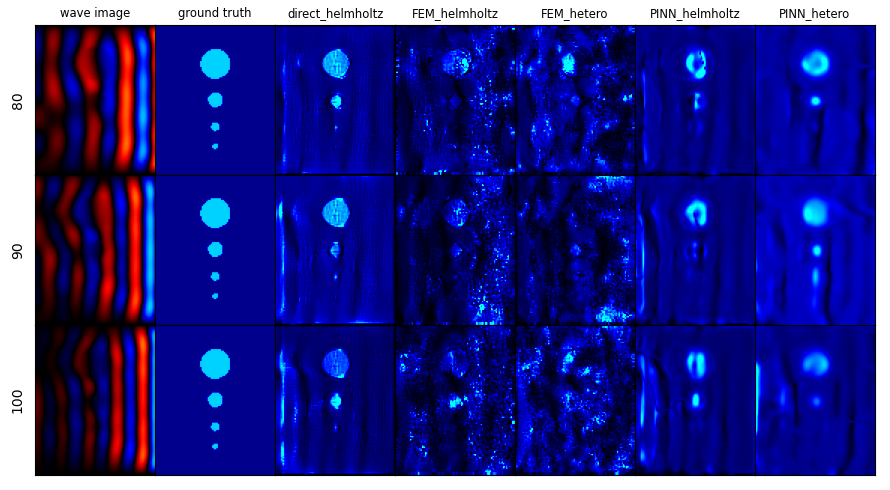

Loading ../data/BIOQIC/fem_box/80/wave.nc
Loading ../data/BIOQIC/fem_box/80/mre.nc
Loading ../data/BIOQIC/fem_box/80/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_0e+00_helmholtz/train_fem_box_80_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_0e+00_helmholtz/train_fem_box_80_0e+00_helmholtz_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_0e+00_hetero/train_fem_box_80_0e+00_hetero_fem.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_0e+00_helmholtz/train_fem_box_80_0e+00_helmholtz_elastogram.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_80_0e+00_hetero/train_fem_box_80_0e+00_hetero_elastogram.nc
Loading ../data/BIOQIC/fem_box/90/wave.nc
Loading ../data/BIOQIC/fem_box/90/mre.nc
Loading ../data/BIOQIC/fem_box/90/mre_mask.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_0e+00_helmholtz/train_fem_box_90_0e+00_helmholtz_direct.nc
Loading 2022-12-1_fem_box_noise/train_fem_box_90_0e+00_helmholtz/train_fem_box_90_0e+00_helmholtz_fem.nc

In [107]:
%autoreload
import mre_pinn

image_names = ['wave image', 'ground truth', 'direct_helmholtz', 'FEM_helmholtz', 'FEM_hetero', 'PINN_helmholtz', 'PINN_hetero']


def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.2
    ax_height = ax_width / 0.8
    
    data_name = 'fem_box'
    noise_ratio = 0.0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25))
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', example_id)
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(example_id, fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave.sel(component='z', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = array.real

            elif image_name == 'ground truth':
                array = example.mre.sel(z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'direct_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)
                
            elif image_name == 'FEM_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'FEM_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_helmholtz':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='helmholtz', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            elif image_name == 'PINN_hetero':
                job_name = name.format(
                    data_name=data_name, example_id=example_id, pde_name='hetero', noise_ratio=noise_ratio
                )
                nc_file = f'{expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=0)
                color_kws = mre_pinn.visual.get_color_kws(array)
                color_kws['vmin'] = -color_kws['vmax']
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array, **color_kws)
            
    return fig

fig0 = plot_image_grid(['50', '60', '70'])
fig1= plot_image_grid(['80', '90', '100'])

for ext in ['png', 'pdf']:
    fig0.savefig(f'images/fem_box_example_grid0.{ext}', bbox_inches='tight', dpi=200)
    fig1.savefig(f'images/fem_box_example_grid1.{ext}', bbox_inches='tight', dpi=200)